In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import starbars as sb

In [ ]:
# Change this to your batch run directory: batch_run_YYYYMMDD_HHMMSS
batch_run = "batch_run_YYYYMMDD_HHMMSS"
dir = f"./batch_results/{batch_run}/"

In [3]:
batch_csv = dir + "summary/batch_results.csv"
batch_df = pd.read_csv(batch_csv)
batch_df.head(5)

,run_id,trained_win_rate,trained_avg_reward,basic_win_rate,basic_avg_reward,duration,timestamp
0,1,0.4072,-0.1118,0.3861,-0.1551,1203.355054,2025-08-14T00:25:53.828976
1,2,0.3971,-0.1333,0.3861,-0.1620,1124.054982,2025-08-14T00:44:38.537245
2,3,0.3934,-0.1377,0.3927,-0.1457,1152.181492,2025-08-14T01:03:51.488351
3,4,0.3974,-0.1291,0.3893,-0.1485,1136.923097,2025-08-14T01:22:49.004291
4,5,0.3989,-0.1235,0.3972,-0.1395,1143.541720,2025-08-14T01:41:53.091898


### Shapiro-Wilk Normality Test
Monte Carlo simulation is a stochastic process. This means that the distributions of `trained_win_rate`, `trained_avg_reward`, `basic_win_rate`, and `basic_avg_reward` should be normal.

In [4]:
p_trained_win_rate = stats.shapiro(batch_df["trained_win_rate"]).pvalue
p_basic_win_rate = stats.shapiro(batch_df["basic_win_rate"]).pvalue
p_trained_avg_reward = stats.shapiro(batch_df["trained_avg_reward"]).pvalue
p_basic_avg_reward = stats.shapiro(batch_df["basic_avg_reward"]).pvalue

print(f"trained_win_rate is {'normal' if p_trained_win_rate > 0.05 else 'not normal'} (p={p_trained_win_rate:.4f})")
print(f"basic_win_rate is {'normal' if p_basic_win_rate > 0.05 else 'not normal'} (p={p_basic_win_rate:.4f})")
print(f"trained_avg_reward is {'normal' if p_trained_avg_reward > 0.05 else 'not normal'} (p={p_trained_avg_reward:.4f})")
print(f"basic_avg_reward is {'normal' if p_basic_avg_reward > 0.05 else 'not normal'} (p={p_basic_avg_reward:.4f})")

trained_win_rate is normal (p=0.2695)
basic_win_rate is normal (p=0.1444)
trained_avg_reward is normal (p=0.3903)
basic_avg_reward is normal (p=0.7941)


### Paired t-Test
Because we have validated that the random variables are normally distributed, we will compare the win rates and average rewards between the trained model and basic strategy using the paired t-test. Otherwise, we would use a non-parametric test like the Wilcoxon signed-rank test.

In [5]:
p_wr = stats.ttest_rel(batch_df["trained_win_rate"], batch_df["basic_win_rate"]).pvalue
p_ar = stats.ttest_rel(batch_df["trained_avg_reward"], batch_df["basic_avg_reward"]).pvalue

print(f"The difference in win rates is {'significant' if p_wr < 0.05 else 'not significant'} (p={p_wr:.5f})")
print(f"The difference in average rewards is {'significant' if p_ar < 0.05 else 'not significant'} (p={p_ar:.5f})")

The difference in win rates is significant (p=0.00000)
The difference in average rewards is significant (p=0.00000)


### Box-and-Whiskers Plot
Now we visualize how their distributions compare to each other.

2.0 0.03
2.0 0.03


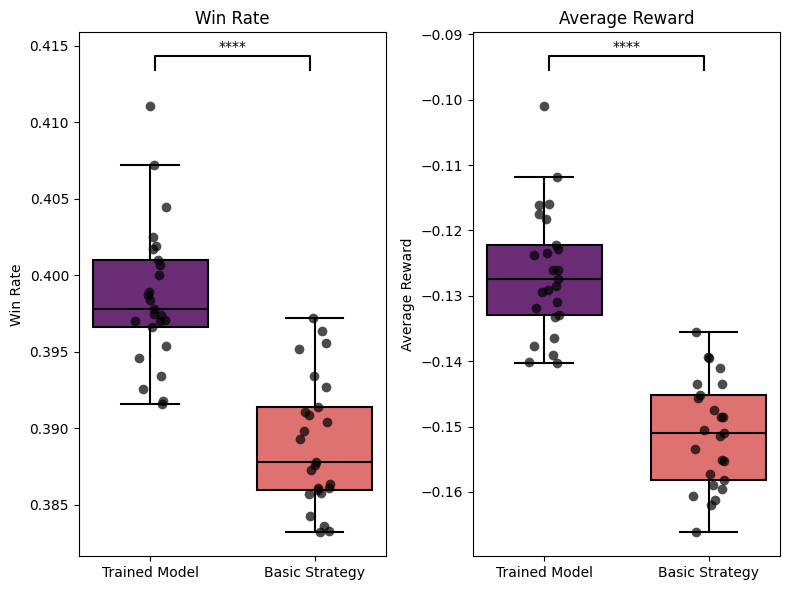

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey=False)

data_wr = batch_df.rename(
    columns={"trained_win_rate": "Trained Model", "basic_win_rate": "Basic Strategy"}
).melt(
    value_vars=["Trained Model", "Basic Strategy"],
    var_name="Model", value_name="Win Rate"
)

sns.boxplot(
    x="Model", y="Win Rate", data=data_wr,
    linewidth=1.5, linecolor="black", width=0.7,
    palette="magma", hue="Model", showfliers=False,
    ax=axes[0]
)
sns.stripplot(
    x="Model", y="Win Rate", data=data_wr,
    color="black", size=7, jitter=True, alpha=0.7, ax=axes[0]
)
axes[0].set_xlabel("")
axes[0].set_title("Win Rate")
sb.draw_annotation([("Trained Model", "Basic Strategy", p_wr)], ax=axes[0])

data_ar = batch_df.rename(
    columns={"trained_avg_reward": "Trained Model", "basic_avg_reward": "Basic Strategy"}
).melt(
    value_vars=["Trained Model", "Basic Strategy"],
    var_name="Model", value_name="Average Reward"
)

sns.boxplot(
    x="Model", y="Average Reward", data=data_ar,
    linewidth=1.5, linecolor="black", width=0.7,
    palette="magma", hue="Model", showfliers=False,
    ax=axes[1],
)
sns.stripplot(
    x="Model", y="Average Reward", data=data_ar,
    color="black", size=7, jitter=True, alpha=0.7, ax=axes[1]
)
axes[1].set_xlabel("")
axes[1].set_title("Average Reward")
sb.draw_annotation([("Trained Model", "Basic Strategy", p_ar)], ax=axes[1])

plt.tight_layout()
plt.show()


Our trained model performs more optimally in maximizing the player's chances of winning each hand compared to relying on basic strategy.

### Finding Optimal Actions for Each Combinations (Trained Model)
We're going to dive into the individual tabular datasets produced in each of the 25 runs to understand the optimal actions the trained model takes at every possible combination.

In [7]:
states_df = pd.read_csv("./csv/blackjack_states.csv")
trained_merged_df = states_df.copy()

for i in range(1, 26):
    file_num = f"{i:03d}"  # 001, 002, ..., 025
    run_df = pd.read_csv(f"{dir}csv_files/run_{file_num}_trained_strategy.csv")
    cols_to_add = ["best_action", "ev"]
    run_df_subset = run_df[['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double'] + cols_to_add].copy()
    run_df_subset.rename(columns={col: f"{col}_{file_num}" for col in cols_to_add}, inplace=True)

    trained_merged_df = pd.merge(
        trained_merged_df,
        run_df_subset,
        on=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double'],
        how='outer'
    )

trained_merged_df["run_nan_count"] = trained_merged_df.apply(lambda row: int((row.isna().sum())/2), axis=1)
trained_merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action_001,ev_001,best_action_002,ev_002,best_action_003,...,ev_021,best_action_022,ev_022,best_action_023,ev_023,best_action_024,ev_024,best_action_025,ev_025,run_nan_count
0,4,1,False,False,True,NaN,NaN,Hit,0.0000,Double,...,-1.5000,Hit,0.0000,Stand,0.0000,Stand,-0.9800,Double,-1.9800,5
1,4,1,False,True,True,Double,-0.7660,Hit,-0.7070,Double,...,-0.7242,Hit,-0.6133,Hit,-0.6449,Stand,-0.7821,Stand,-0.7706,0
2,4,2,False,False,True,NaN,NaN,Double,2.0400,NaN,...,0.0000,Stand,-1.9800,NaN,NaN,Double,0.3032,Double,2.0400,8
3,4,2,False,True,True,Hit,-0.1838,Stand,-0.2319,Hit,...,0.2100,Hit,-0.1055,Stand,-0.2778,Split,-0.2081,Hit,-0.2164,0
4,4,3,False,False,True,Double,-1.9600,Hit,0.0000,Double,...,0.0000,Double,-0.1878,Double,-0.4809,Hit,0.0327,Hit,2.0100,3


In [8]:
# Check for row duplicates
if trained_merged_df.duplicated(subset=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double']).any():
    print("Duplicated rows found.")
else:
    print("No duplicate rows found.")

# Count of NaN values in run columns
trained_merged_df["run_nan_count"].value_counts().sort_index(ascending=False).reset_index().T

No duplicate rows found.


,0,1,2,3,4,5,6,7,8,9
run_nan_count,9,8,7,6,5,4,3,2,1,0
count,2,1,6,4,5,2,5,8,10,557


In [9]:
trained_best_action_cols = [col for col in trained_merged_df.columns if col.startswith("best_action_")]
trained_ev_cols = [col for col in trained_merged_df.columns if col.startswith("ev_")]

trained_best_action_cols.sort()
trained_ev_cols.sort()

def get_best_action_and_ev(row, ba_cols, ev_cols, track_source=False):
    actions = ["Hit", "Stand", "Split", "Double"]
    action_mean_evs = {}
    action_sources = {}

    for action in actions:
        evs_for_action = []
        sources_for_action = []

        for ba_col, ev_col in zip(ba_cols, ev_cols):
            if row[ba_col] == action and pd.notna(row[ev_col]):
                evs_for_action.append(row[ev_col])
                sources_for_action.append(ba_col.replace("best_action_", ""))

        if evs_for_action:
            action_mean_evs[action] = np.mean(evs_for_action)
            action_sources[action] = sources_for_action

    if not action_mean_evs:
        return (np.nan, np.nan, np.nan) if track_source else (np.nan, np.nan)

    best_action = max(action_mean_evs, key=action_mean_evs.get)
    best_ev = action_mean_evs[best_action]

    if track_source:
        best_sources = ", ".join(action_sources[best_action])
        return best_action, best_ev, best_sources
    else:
        return best_action, best_ev
    
trained_merged_df[["best_action", "ev"]] = trained_merged_df.apply(
    lambda row: pd.Series(get_best_action_and_ev(row, trained_best_action_cols, trained_ev_cols)), axis=1
)

trained_merged_df = trained_merged_df[["player_sum", "dealer_visible", "usable_ace", "can_split", "can_double", "best_action", "ev"]]
trained_merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action,ev
0,4,1,False,False,True,Stand,-4.900000e-01
1,4,1,False,True,True,Hit,-6.761100e-01
2,4,2,False,False,True,Double,1.284640e+00
3,4,2,False,True,True,Split,-9.251859e-18
4,4,3,False,False,True,Stand,2.000000e+00


### Finding Optimal Actions for Each Combinations (Basic Strategy Model)
We'll now do the same for the basic strategy model.

In [10]:
bs_merged_df = states_df.copy()

for i in range(1, 26):
    file_num = f"{i:03d}"  # 001, 002, ..., 025
    run_df = pd.read_csv(f"{dir}csv_files/run_{file_num}_basic_strategy.csv")
    cols_to_add = ["best_action", "ev"]
    run_df_subset = run_df[['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double'] + cols_to_add].copy()
    run_df_subset.rename(columns={col: f"{col}_{file_num}" for col in cols_to_add}, inplace=True)

    bs_merged_df = pd.merge(
        bs_merged_df,
        run_df_subset,
        on=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double'],
        how='outer'
    )

bs_merged_df["run_nan_count"] = bs_merged_df.apply(lambda row: int((row.isna().sum())/2), axis=1)
bs_merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action_001,ev_001,best_action_002,ev_002,best_action_003,...,ev_021,best_action_022,ev_022,best_action_023,ev_023,best_action_024,ev_024,best_action_025,ev_025,run_nan_count
0,4,1,False,True,True,Hit,-0.6928,Hit,-0.6483,Hit,...,-0.5956,Hit,-0.7327,Hit,-0.6005,Hit,-0.6294,Hit,-0.6976,0
1,4,2,False,True,True,Hit,-0.1320,Hit,-0.2133,Hit,...,-0.1161,Hit,-0.2066,Hit,-0.1415,Hit,-0.2199,Hit,-0.1255,0
2,4,3,False,True,True,Hit,-0.2513,Hit,-0.0866,Hit,...,-0.1392,Hit,-0.0893,Hit,-0.1912,Hit,-0.1096,Hit,-0.2013,0
3,4,4,False,False,True,Hit,-0.1140,Hit,-0.1388,Hit,...,-0.3353,Hit,0.0224,Hit,-0.3161,Hit,0.1507,Hit,-0.0498,0
4,4,4,False,True,True,Split,-0.1074,Split,-0.0614,Split,...,-0.0455,Split,-0.0056,Split,-0.1739,Split,0.0410,Split,-0.0521,0


In [11]:
# Check for row duplicates
if bs_merged_df.duplicated(subset=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double']).any():
    print("Duplicated rows found.")
else:
    print("No duplicate rows found.")

# Count of NaN values in run columns
bs_merged_df["run_nan_count"].value_counts().sort_index(ascending=False).reset_index().T

No duplicate rows found.


,0,1,2,3
run_nan_count,25,15,1,0
count,10,1,2,581


Unlike the trained agent data, we see 10 state combinations the basic strategy model never managed to encounter over the 25 repeated simulations. Therefore, we should assess these combinations and try to understand why this happened.

In [12]:
print(f"Unique player_sum values: {bs_merged_df[bs_merged_df['run_nan_count'] == 25]['player_sum'].unique()}")
print(f"Unique dealer_visible values: {bs_merged_df[bs_merged_df['run_nan_count'] == 25]['dealer_visible'].unique()}")
print(f"Unique usable_ace values: {bs_merged_df[bs_merged_df['run_nan_count'] == 25]['usable_ace'].unique()}")
print(f"Unique can_split values: {bs_merged_df[bs_merged_df['run_nan_count'] == 25]['can_split'].unique()}")
print(f"Unique can_double values: {bs_merged_df[bs_merged_df['run_nan_count'] == 25]['can_double'].unique()}")

bs_merged_df[bs_merged_df["run_nan_count"] == 25][["player_sum", "dealer_visible", "usable_ace", "can_split", "can_double"]]

Unique player_sum values: [20]
Unique dealer_visible values: [ 1  2  3  4  5  6  7  8  9 10]
Unique usable_ace values: [False]
Unique can_split values: [False]
Unique can_double values: [ True]


,player_sum,dealer_visible,usable_ace,can_split,can_double
545,20,1,False,False,True
550,20,2,False,False,True
555,20,3,False,False,True
560,20,4,False,False,True
565,20,5,False,False,True
570,20,6,False,False,True
575,20,7,False,False,True
580,20,8,False,False,True
585,20,9,False,False,True
590,20,10,False,False,True


It seems like all scenarios in which the player has two 10s on a split hand are undiscovered by the basic strategy model. This is expected as the only way to obtain double 10s on split hands is if you've split 10s in the previous step and drew a 10 on the split hand(s). However, the basic strategy model always stands on double 10s. Hence, it will never encounter a post-split `player_sum = 20` where `can_double = True`.

In [13]:
bs_best_action_cols = [col for col in bs_merged_df.columns if col.startswith("best_action_")]
bs_ev_cols = [col for col in bs_merged_df.columns if col.startswith("ev_")]

bs_best_action_cols.sort()
bs_ev_cols.sort()

bs_merged_df[["best_action", "ev"]] = bs_merged_df.apply(
    lambda row: pd.Series(get_best_action_and_ev(row, bs_best_action_cols, bs_ev_cols)), axis=1
)

bs_merged_df = bs_merged_df[["player_sum", "dealer_visible", "usable_ace", "can_split", "can_double", "best_action", "ev"]]
bs_merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action,ev
0,4,1,False,True,True,Hit,-0.646860
1,4,2,False,True,True,Hit,-0.165320
2,4,3,False,True,True,Hit,-0.152308
3,4,4,False,False,True,Hit,-0.128480
4,4,4,False,True,True,Split,-0.051096


In [14]:
result = bs_merged_df[
    (bs_merged_df['player_sum'] == 12) & 
    (bs_merged_df['dealer_visible'] == 7) & 
    (bs_merged_df['usable_ace'] == True) & 
    (bs_merged_df['can_split'] == False) & 
    (bs_merged_df['can_double'] == True)
]

# Display the resulting row(s)
print(result)

     player_sum  dealer_visible  usable_ace  can_split  can_double  \
214          12               7        True      False        True   

    best_action       ev  
214         Hit  0.23772  


### Merge Results from Both Models

In [15]:
merged_df = pd.merge(
    trained_merged_df,
    bs_merged_df,
    on=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double'],
    how='outer',
    suffixes=('_trained', '_basic')
)

# Check for row duplicates
if merged_df.duplicated(subset=['player_sum', 'dealer_visible', 'usable_ace', 'can_split', 'can_double']).any():
    print("Duplicated rows found.")
else:
    print("No duplicate rows found.")

# Count of NaN values in run columns
merged_df["run_nan_count"] = merged_df.apply(lambda row: int((row.isna().sum())/2), axis=1)
merged_df["run_nan_count"].value_counts().sort_index(ascending=False).reset_index().T

No duplicate rows found.


,0,1
run_nan_count,1,0
count,16,584


In [16]:
best_action_cols = [col for col in merged_df.columns if col.startswith("best_action_")]
ev_cols = [col for col in merged_df.columns if col.startswith("ev_")]

best_action_cols.sort()
ev_cols.sort()

merged_df[["best_action", "ev", "source"]] = merged_df.apply(
    lambda row: pd.Series(get_best_action_and_ev(row, best_action_cols, ev_cols, track_source=True)), axis=1
)

merged_df = merged_df[["player_sum", "dealer_visible", "usable_ace", "can_split", "can_double", "best_action", "ev","source"]]
merged_df.head()

,player_sum,dealer_visible,usable_ace,can_split,can_double,best_action,ev,source
0,4,1,False,False,True,Stand,-4.900000e-01,trained
1,4,1,False,True,True,Hit,-6.614850e-01,"basic, trained"
2,4,2,False,False,True,Double,1.284640e+00,trained
3,4,2,False,True,True,Split,-9.251859e-18,trained
4,4,3,False,False,True,Stand,2.000000e+00,trained


In [17]:
print(f"There are {merged_df.isna().any(axis=1).sum()} rows with missing action data before dropping.")

merged_cleaned_df = merged_df.dropna()
print(f"There are {merged_cleaned_df.isna().any(axis=1).sum()} rows with missing action data after dropping.")

There are 0 rows with missing action data before dropping.
There are 0 rows with missing action data after dropping.


In [18]:
merged_cleaned_df.to_csv("merged_results.csv", index=False)

### Performance Analysis

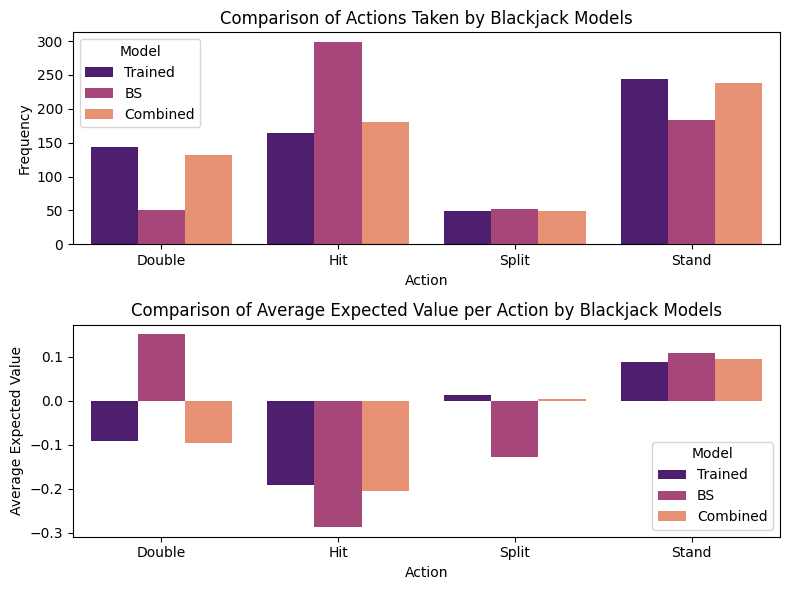

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharey=False)

actions_df = pd.DataFrame({
    "Trained": trained_merged_df["best_action"].value_counts(),
    "BS": bs_merged_df["best_action"].value_counts(),
    "Combined": merged_cleaned_df["best_action"].value_counts()
}).reset_index(names="Action").melt(
    id_vars="Action", var_name="Model", value_name="Frequency"
)

sns.barplot(data=actions_df, x="Action", y="Frequency", hue="Model", palette="magma", ax=axes[0])
axes[0].set_title("Comparison of Actions Taken by Blackjack Models")
axes[0].set_xlabel("Action")

avg_ev_df = pd.DataFrame({
    "Trained": trained_merged_df.groupby("best_action")["ev"].mean(),
    "BS": bs_merged_df.groupby("best_action")["ev"].mean(),
    "Combined": merged_cleaned_df.groupby("best_action")["ev"].mean()
}).reset_index(names="Action").melt(
    id_vars="Action", var_name="Model", value_name="Average Expected Value"
)

sns.barplot(data=avg_ev_df, x="Action", y="Average Expected Value", hue="Model", palette="magma", ax=axes[1])
axes[1].set_title("Comparison of Average Expected Value per Action by Blackjack Models")
axes[1].set_xlabel("Action")

plt.tight_layout()
plt.show()

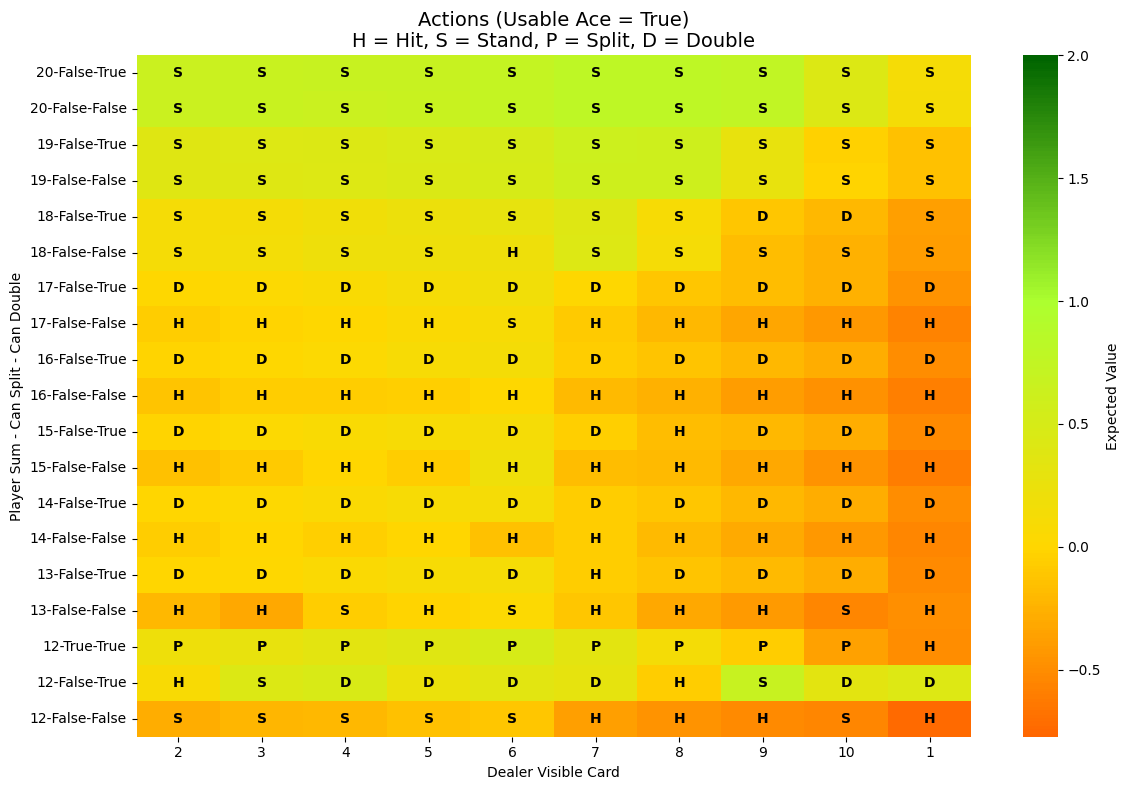

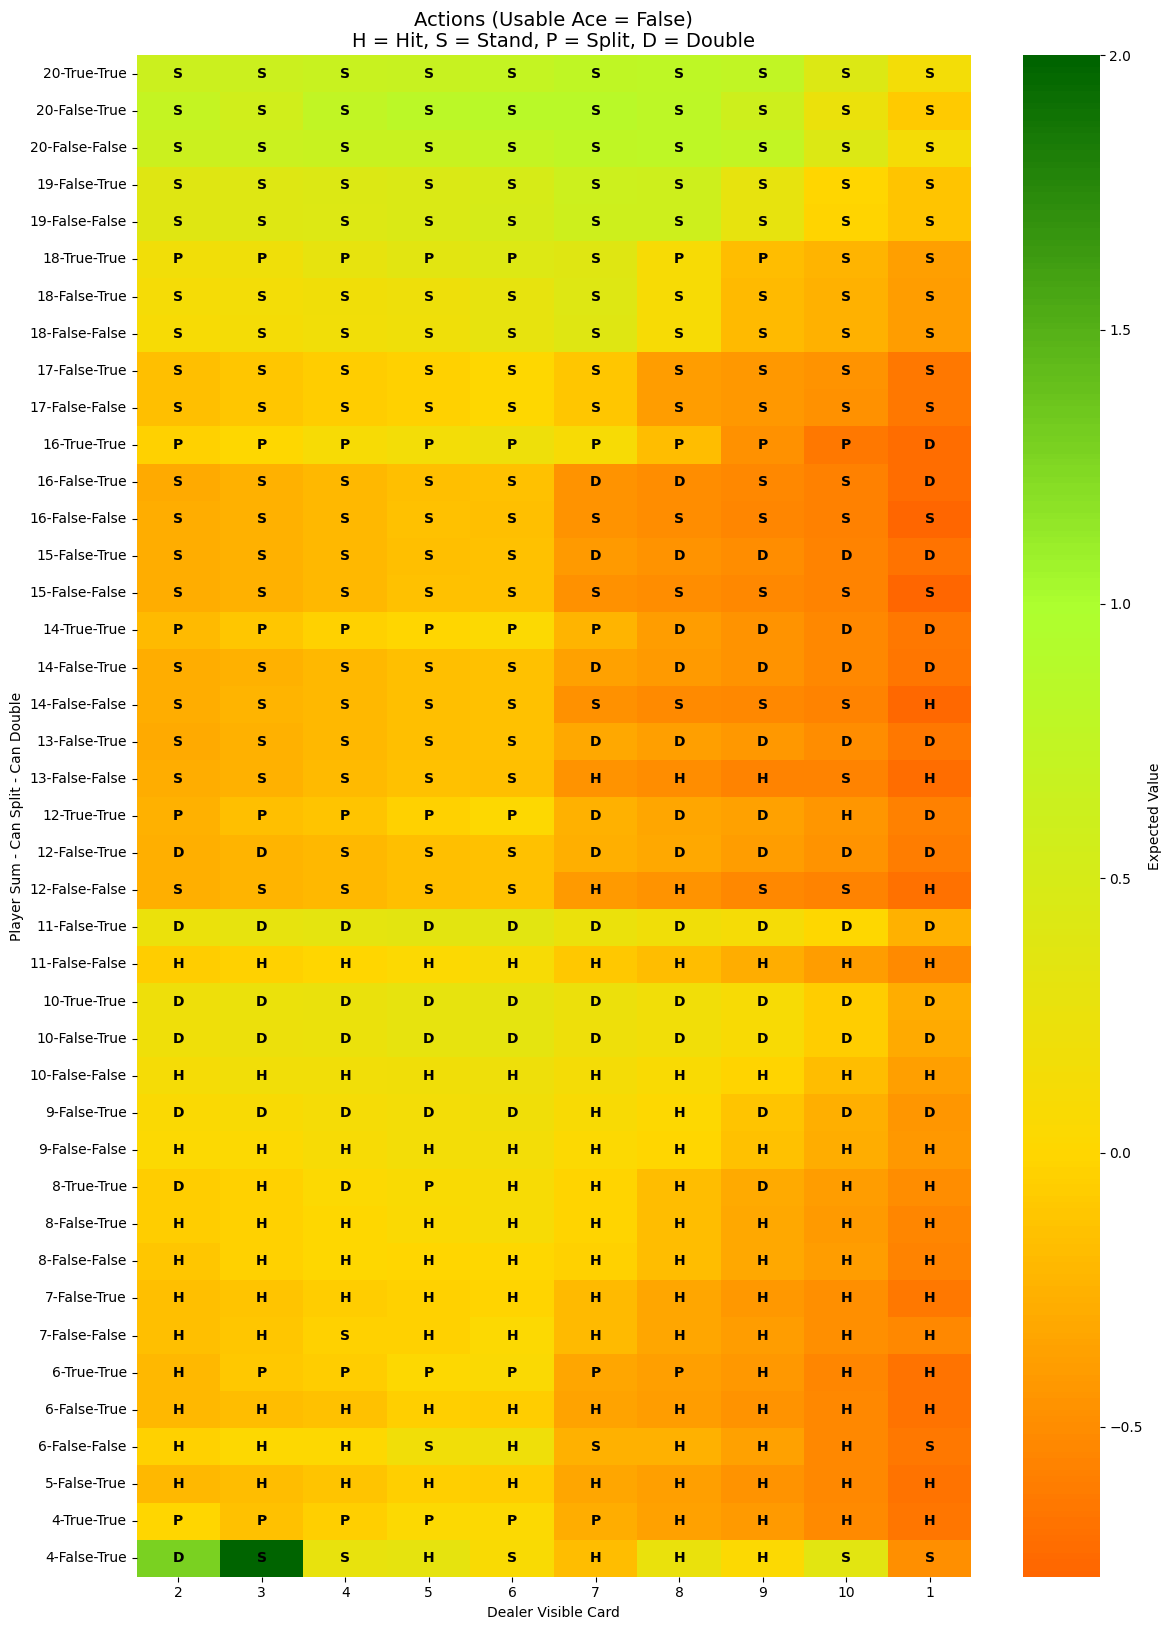

In [20]:
from matplotlib.colors import LinearSegmentedColormap

state_cols = ["player_sum", "dealer_visible", "usable_ace", "can_split", "can_double"]

comparison_df = merged_cleaned_df.merge(
    bs_merged_df[state_cols + ["best_action", "ev"]],
    on=state_cols, how="left", suffixes=("_cm", "_bs")
)

# Action symbol mapping
action_symbols = {
    "Hit": "H",
    "Stand": "S",
    "Split": "P",
    "Double": "D"
}

# Colormap & EV range
custom_cmap = LinearSegmentedColormap.from_list(
    'custom', ['#8B0000', '#FF4500', '#FFD700', '#ADFF2F', '#006400']
)
vmin, vmax = comparison_df["ev_cm"].min(), comparison_df["ev_cm"].max()

def create_heatmap(df, usable_ace_value, title_suffix):
    df = df[df["usable_ace"] == usable_ace_value]
    if df.empty: return print(f"No data for usable_ace={usable_ace_value}")
    
    ev_pivot = df.pivot_table(
        index=["player_sum", "can_split", "can_double"], 
        columns="dealer_visible", values="ev_cm", aggfunc="mean"
    )
    action_pivot = df.pivot_table(
        index=["player_sum", "can_split", "can_double"], 
        columns="dealer_visible", values="best_action_cm", aggfunc="first"
    )

    # Sort & reorder dealer columns (Ace last)
    order = sorted(ev_pivot.index, reverse=True)
    dealer_order = [c for c in ev_pivot.columns if c != 1] + [1]
    ev_pivot = ev_pivot.reindex(order)[dealer_order]
    action_pivot = action_pivot.reindex(order)[dealer_order]

    # Heatmap
    fig, ax = plt.subplots(figsize=(12, max(8, len(ev_pivot) * 0.4)))
    sns.heatmap(ev_pivot, annot=False, fmt=".3f", cmap=custom_cmap,
                center=0, vmin=vmin, vmax=vmax, ax=ax,
                cbar_kws={"label": "Expected Value"})

    # Overlay action symbols
    for i in range(len(ev_pivot.index)):
        for j in range(len(ev_pivot.columns)):
            act = action_pivot.iloc[i, j]
            if pd.notna(act):
                ax.text(j + 0.5, i + 0.5, action_symbols.get(act, "?"),
                        ha='center', va='center', fontsize=10, color="black", weight="bold")

    ax.set_title(f"Actions {title_suffix}\nH = Hit, S = Stand, P = Split, D = Double",
                 fontsize=14)
    ax.set_xlabel("Dealer Visible Card")
    ax.set_ylabel("Player Sum - Can Split - Can Double")
    plt.tight_layout()
    plt.show()

create_heatmap(comparison_df, True, "(Usable Ace = True)")
create_heatmap(comparison_df, False, "(Usable Ace = False)")


In [21]:
uniq_source_counts = merged_cleaned_df["source"].value_counts()

print(f"SOURCE\n\
- Both agree:     {uniq_source_counts.iloc[0]} state-action combinations\n\
- Trained Agent:  {uniq_source_counts.iloc[1]} state-action combinations\n\
- Basic Strategy: {uniq_source_counts.iloc[2]} state-action combinations")

SOURCE
- Both agree:     425 state-action combinations
- Trained Agent:  158 state-action combinations
- Basic Strategy: 17 state-action combinations
